In [1]:
### v1.1

# Task 1: Bear and Non-bear classification using transfer learning: Comparing MobileNet v2 and MobileNet v3Small

## 1 Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2024-08-17 20:27:46.782223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 20:27:46.782262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 20:27:46.782899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 20:27:46.786623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 20:27:47.429064: W tensorflow/compiler/tf2

### 1.1 Create the Dataset and Split it into Training and Validation Sets


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "Datasets/"
# train_dataset = image_dataset_from_directory(directory,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              validation_split=0.2,
#                                              subset='training',
#                                              seed=42)
# validation_dataset = image_dataset_from_directory(directory,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              validation_split=0.2,
#                                              subset='validation',
#                                              seed=42)

In [3]:
validation_split = 0.2
test_split = 0.2  # Portion of data to use as test data
seed = 42

# Load the full dataset without splitting
full_dataset = image_dataset_from_directory(directory,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE,
                                            seed=seed)

# Calculate the number of samples in each dataset
total_samples = len(full_dataset)
val_size = int(total_samples * validation_split)
test_size = int(total_samples * test_split)
train_size = total_samples - val_size - test_size

# Split the dataset
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
validation_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# # Optional: Prefetch to improve performance
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



Found 954 files belonging to 2 classes.


2024-08-17 20:27:54.151833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14791 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2024-08-17 20:27:54.347746: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


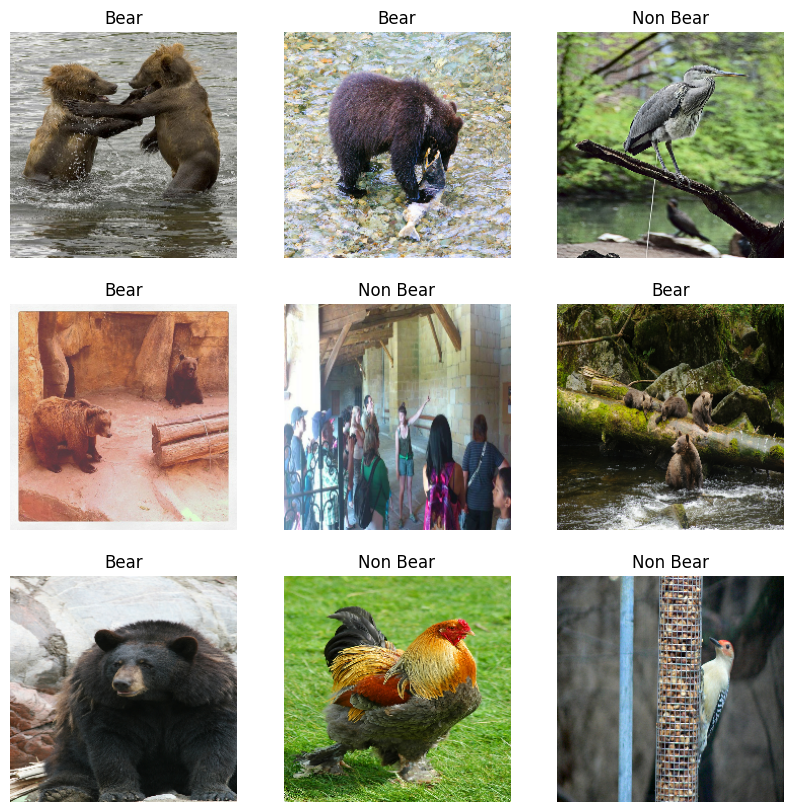

In [4]:
class_names = full_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # take(1) means take a batch which are 32 images
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

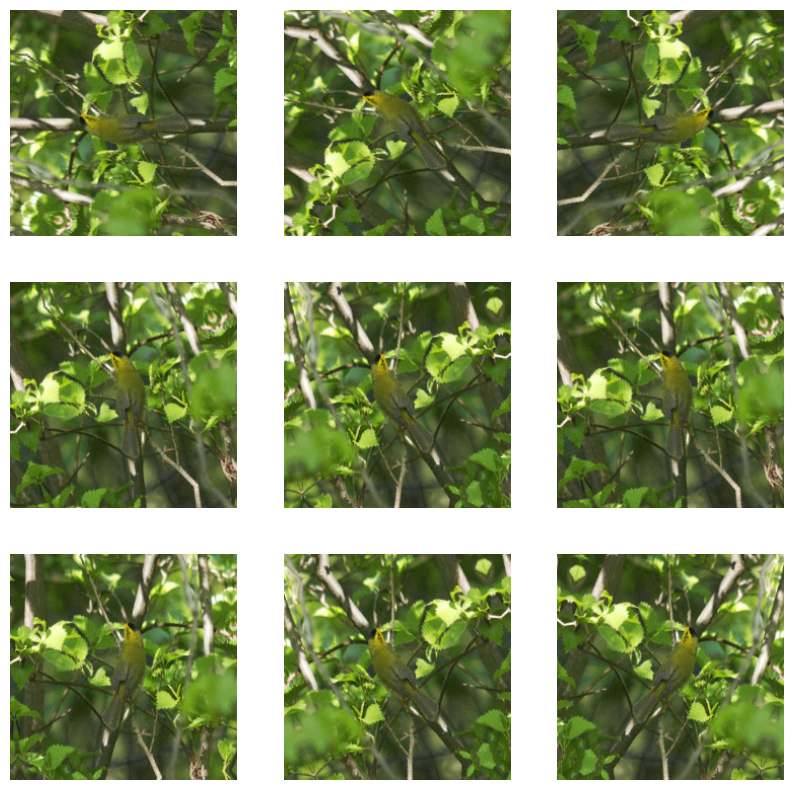

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # tf.expand_dims(first_image, 0): from (224, 224, 3) to (1, 224, 224, 3)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) 
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 2 MobileNet V2

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
##
IMG_SIZE+(3,)

(224, 224, 3)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [12]:
base_model_v2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [13]:
nb_layers = len(base_model_v2.layers)
print(base_model_v2.layers[nb_layers - 2].name)
print(base_model_v2.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_v2(image_batch)
print(feature_batch.shape)

(32, 1000)


2024-08-17 14:13:58.846506: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-08-17 14:13:58.900637: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [15]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int32)>

In [16]:
base_model_v2.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model_v2(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)


[[('n02132136', 'brown_bear', 0.4005452),
  ('n02134418', 'sloth_bear', 0.32191682)],
 [('n02132136', 'brown_bear', 0.28788137),
  ('n02133161', 'American_black_bear', 0.27219978)],
 [('n02132136', 'brown_bear', 0.33460364), ('n02444819', 'otter', 0.20364162)],
 [('n01514668', 'cock', 0.60095584), ('n01514859', 'hen', 0.105649225)],
 [('n02133161', 'American_black_bear', 0.82505727),
  ('n02134418', 'sloth_bear', 0.05092079)],
 [('n01729322', 'hognose_snake', 0.8676289),
  ('n01737021', 'water_snake', 0.04375689)],
 [('n02128385', 'leopard', 0.1862418), ('n02129604', 'tiger', 0.091559544)],
 [('n02727426', 'apiary', 0.9973864),
  ('n02672831', 'accordion', 0.00030009824)],
 [('n02132136', 'brown_bear', 0.23797275),
  ('n02480855', 'gorilla', 0.06951718)],
 [('n02132136', 'brown_bear', 0.9753236),
  ('n02444819', 'otter', 0.0053977612)],
 [('n01819313', 'sulphur-crested_cockatoo', 0.6978597),
  ('n02002556', 'white_stork', 0.022090426)],
 [('n02132136', 'brown_bear', 0.9864938),
  ('n02

#### Brown bear is already in the label. We do not need exact types of other classes, so we just change it to a binary classifier 

In [17]:
def bear_model_v2(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 160, 160, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 160, 160, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 160, 160, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [18]:
model_v2 = bear_model_v2(IMG_SIZE, data_augmentation)

In [19]:
base_learning_rate = 0.001
model_v2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# Add callback
# callback = tf.keras.callbacks.EarlyStopping(patience=4)
initial_epochs = 50
# history_v2 = model_v2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v2 = model_v2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
 3/18 [====>.........................] - ETA: 0s - loss: 0.7244 - accuracy: 0.5938 

2024-08-17 14:14:03.111870: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f308c5b2820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-17 14:14:03.111901: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-08-17 14:14:03.115436: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723896843.167217  126426 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 5s 106ms/step - loss: 0.4990 - accuracy: 0.7240 - val_loss: 0.2638 - val_accuracy: 0.8854
Epoch 2/50
18/18 [==============================] - 2s 81ms/step - loss: 0.2249 - accuracy: 0.9271 - val_loss: 0.1646 - val_accuracy: 0.9167
Epoch 3/50
18/18 [==============================] - 2s 79ms/step - loss: 0.1559 - accuracy: 0.9462 - val_loss: 0.1349 - val_accuracy: 0.9427
Epoch 4/50
18/18 [==============================] - 2s 81ms/step - loss: 0.1281 - accuracy: 0.9688 - val_loss: 0.1409 - val_accuracy: 0.9479
Epoch 5/50
18/18 [==============================] - 2s 79ms/step - loss: 0.1335 - accuracy: 0.9566 - val_loss: 0.0739 - val_accuracy: 0.9896
Epoch 6/50
18/18 [==============================] - 2s 80ms/step - loss: 0.1114 - accuracy: 0.9549 - val_loss: 0.0834 - val_accuracy: 0.9688
Epoch 7/50
18/18 [==============================] - 2s 79ms/step - loss: 0.1329 - accuracy: 0.9549 - val_loss: 0.0768 - val_accuracy: 0.9740
Epoch 8/50
18/18 [=====

Plot the training and validation accuracy:

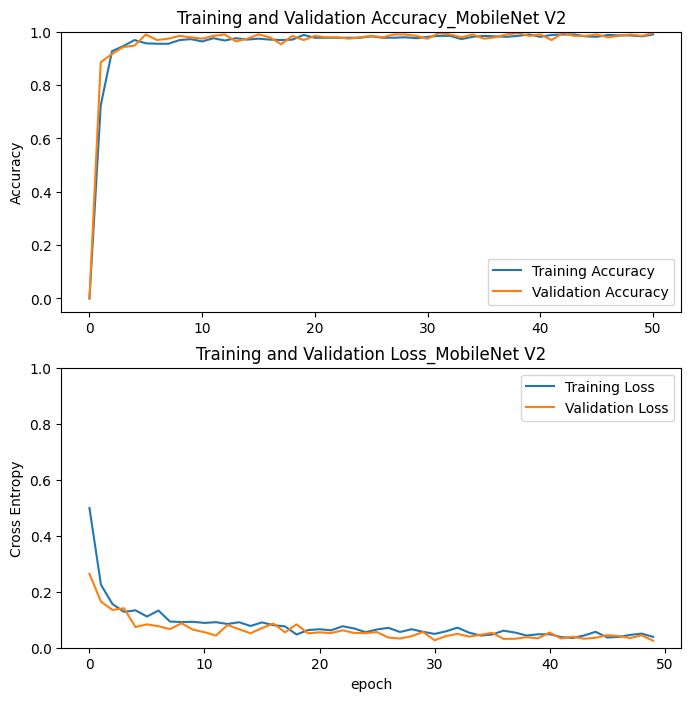

In [21]:
acc_v2 = [0.] + history_v2.history['accuracy']
val_acc_v2 = [0.] + history_v2.history['val_accuracy']

loss_v2 = history_v2.history['loss']
val_loss_v2 = history_v2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v2, label='Training Accuracy')
plt.plot(val_acc_v2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_MobileNet V2')

plt.subplot(2, 1, 2)
plt.plot(loss_v2, label='Training Loss')
plt.plot(val_loss_v2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_MobileNet V2')
plt.xlabel('epoch')
plt.show()

In [22]:
class_names

['Bear', 'Non Bear']

In [23]:
model_v2.evaluate(test_dataset)

6/6 [==============================] - 1s 99ms/step - loss: 0.0348 - accuracy: 0.9839


[0.034829284995794296, 0.9838709831237793]

In [70]:
l,acc = model_v2.evaluate(test_dataset)

6/6 [==============================] - 1s 21ms/step - loss: 0.0234 - accuracy: 0.9892


In [71]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_v2.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.9407 seconds; Average test accuracy: 0.9896057446797689


In [25]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    model_v2.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)

print(f"Average time per evaluation run: {average_time:.4f} seconds")

Average time per evaluation run: 0.9412 seconds


## 3 MobileNetV3 Small

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [27]:
IMG_SIZE+(3,)

(224, 224, 3)

In [28]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v3_s = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
# base_model_v3.summary()

In [29]:
nb_layers = len(base_model_v3_s.layers)
print(base_model_v3_s.layers[nb_layers - 2].name)
print(base_model_v3_s.layers[nb_layers - 1].name)

flatten
Predictions


In [30]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_v3_s(image_batch)
print(feature_batch.shape)

(32, 1000)


In [31]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)>

In [32]:
base_model_v3_s.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model_v3_s(image_var)

tf.keras.applications.mobilenet_v3.decode_predictions(pred.numpy(), top=2)


[[('n02132136', 'brown_bear', 0.79399914),
  ('n02096051', 'Airedale', 0.052825436)],
 [('n02132136', 'brown_bear', 0.48617706),
  ('n02125311', 'cougar', 0.10237181)],
 [('n02011460', 'bittern', 0.88915974), ('n01608432', 'kite', 0.029716942)],
 [('n02410509', 'bison', 0.5363064), ('n02132136', 'brown_bear', 0.15632728)],
 [('n02236044', 'mantis', 0.97634083),
  ('n02231487', 'walking_stick', 0.010836587)],
 [('n03599486', 'jinrikisha', 0.1931468), ('n03141823', 'crutch', 0.0937669)],
 [('n02102973', 'Irish_water_spaniel', 0.5261503),
  ('n02099429', 'curly-coated_retriever', 0.08980346)],
 [('n02417914', 'ibex', 0.14262098), ('n02442845', 'mink', 0.10721902)],
 [('n02132136', 'brown_bear', 0.30909443),
  ('n02457408', 'three-toed_sloth', 0.20044836)],
 [('n02132136', 'brown_bear', 0.89049304),
  ('n02077923', 'sea_lion', 0.03058273)],
 [('n01950731', 'sea_slug', 0.9372788),
  ('n01924916', 'flatworm', 0.008323361)],
 [('n02132136', 'brown_bear', 0.7291103),
  ('n02133161', 'American_

In [33]:
def bear_model_v3_s(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV3 Small model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 160, 160, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 160, 160, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 160, 160, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [34]:
model_v3_s = bear_model_v3_s(IMG_SIZE, data_augmentation)

In [35]:
# callback = tf.keras.callbacks.EarlyStopping(patience=5)
base_learning_rate = 0.001
model_v3_s.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 50
# history_v3_s = model_v3_s.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v3_s = model_v3_s.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
18/18 [==============================] - 4s 99ms/step - loss: 0.6509 - accuracy: 0.6163 - val_loss: 0.4686 - val_accuracy: 0.6927
Epoch 2/50
18/18 [==============================] - 2s 78ms/step - loss: 0.4049 - accuracy: 0.7951 - val_loss: 0.3148 - val_accuracy: 0.8542
Epoch 3/50
18/18 [==============================] - 2s 78ms/step - loss: 0.3076 - accuracy: 0.8715 - val_loss: 0.2257 - val_accuracy: 0.9010
Epoch 4/50
18/18 [==============================] - 2s 79ms/step - loss: 0.2460 - accuracy: 0.8993 - val_loss: 0.1893 - val_accuracy: 0.9271
Epoch 5/50
18/18 [==============================] - 2s 77ms/step - loss: 0.2085 - accuracy: 0.9167 - val_loss: 0.1634 - val_accuracy: 0.9427
Epoch 6/50
18/18 [==============================] - 2s 78ms/step - loss: 0.2173 - accuracy: 0.9253 - val_loss: 0.1627 - val_accuracy: 0.9427
Epoch 7/50
18/18 [==============================] - 2s 76ms/step - loss: 0.1914 - accuracy: 0.9219 - val_loss: 0.1689 - val_accuracy: 0.9219
Epoch 8/50
18

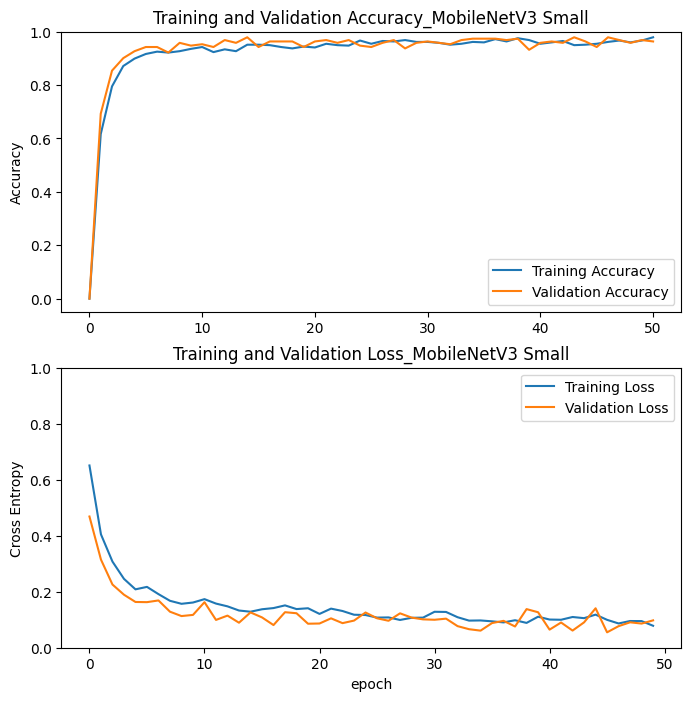

In [36]:
acc_v3_s = [0.] + history_v3_s.history['accuracy']
val_acc_v3_s = [0.] + history_v3_s.history['val_accuracy']

loss_v3_s = history_v3_s.history['loss']
val_loss_v3_s = history_v3_s.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v3_s, label='Training Accuracy')
plt.plot(val_acc_v3_s, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_MobileNetV3 Small')

plt.subplot(2, 1, 2)
plt.plot(loss_v3_s, label='Training Loss')
plt.plot(val_loss_v3_s, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_MobileNetV3 Small')
plt.xlabel('epoch')
plt.show()

In [37]:
model_v3_s.evaluate(test_dataset)

6/6 [==============================] - 1s 93ms/step - loss: 0.0737 - accuracy: 0.9731


[0.07372170686721802, 0.9731183052062988]

In [72]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_v3_s.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy for MobileNetV3_Small: {average_test_accuracy}")

Average time per evaluation run: 0.8998 seconds; Average test accuracy for MobileNetV3_Small: 0.9695340474446614


## 4 MobileNetV3 Large

In [38]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [39]:
IMG_SIZE+(3,)

(224, 224, 3)

In [40]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_v3_l = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
# base_model_v3.summary()

In [41]:
nb_layers = len(base_model_v3_l.layers)
print(base_model_v3_l.layers[nb_layers - 2].name)
print(base_model_v3_l.layers[nb_layers - 1].name)

flatten_1
Predictions


In [42]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_v3_l(image_batch)
print(feature_batch.shape)
print()
print(label_batch)

(32, 1000)

tf.Tensor([1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1], shape=(32,), dtype=int32)


In [43]:
base_model_v3_l.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model_v3_l(image_var)

tf.keras.applications.mobilenet_v3.decode_predictions(pred.numpy(), top=2)


[[('n03495258', 'harp', 0.77201295),
  ('n02443484', 'black-footed_ferret', 0.028821876)],
 [('n02132136', 'brown_bear', 0.43132332), ('n02410509', 'bison', 0.27080244)],
 [('n02132136', 'brown_bear', 0.76648563),
  ('n02363005', 'beaver', 0.050591573)],
 [('n07734744', 'mushroom', 0.2254618), ('n07753113', 'fig', 0.19650365)],
 [('n02410509', 'bison', 0.9841302), ('n02403003', 'ox', 0.0021192236)],
 [('n02129165', 'lion', 0.87562275), ('n02410509', 'bison', 0.04091942)],
 [('n02132136', 'brown_bear', 0.918373),
  ('n02133161', 'American_black_bear', 0.0064483467)],
 [('n01531178', 'goldfinch', 0.102676585), ('n01580077', 'jay', 0.0959277)],
 [('n02132136', 'brown_bear', 0.57314974),
  ('n02133161', 'American_black_bear', 0.100276746)],
 [('n02132136', 'brown_bear', 0.8108084), ('n02410509', 'bison', 0.022369392)],
 [('n01950731', 'sea_slug', 0.95223916),
  ('n01924916', 'flatworm', 0.0030561623)],
 [('n01531178', 'goldfinch', 0.4232603), ('n01560419', 'bulbul', 0.21443948)],
 [('n0151

In [44]:
def bear_model_v3_l(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV3Large model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV3Large(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) # (None, 224, 224, 3)
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) # (None, 224, 224, 3)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [45]:
model_v3_l = bear_model_v3_l(IMG_SIZE, data_augmentation)
# callback = tf.keras.callbacks.EarlyStopping(patience=4)
base_learning_rate = 0.001
model_v3_l.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 50
# history_v3_l = model_v3_l.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, callbacks=[callback])
history_v3_l = model_v3_l.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
18/18 [==============================] - 5s 108ms/step - loss: 0.6171 - accuracy: 0.6406 - val_loss: 0.3411 - val_accuracy: 0.8021
Epoch 2/50
18/18 [==============================] - 2s 79ms/step - loss: 0.2931 - accuracy: 0.8646 - val_loss: 0.1776 - val_accuracy: 0.9427
Epoch 3/50
18/18 [==============================] - 2s 78ms/step - loss: 0.1870 - accuracy: 0.9236 - val_loss: 0.1543 - val_accuracy: 0.9271
Epoch 4/50
18/18 [==============================] - 2s 79ms/step - loss: 0.1655 - accuracy: 0.9375 - val_loss: 0.1199 - val_accuracy: 0.9479
Epoch 5/50
18/18 [==============================] - 2s 80ms/step - loss: 0.1429 - accuracy: 0.9392 - val_loss: 0.1162 - val_accuracy: 0.9375
Epoch 6/50
18/18 [==============================] - 2s 79ms/step - loss: 0.1329 - accuracy: 0.9566 - val_loss: 0.1244 - val_accuracy: 0.9271
Epoch 7/50
18/18 [==============================] - 2s 78ms/step - loss: 0.1269 - accuracy: 0.9566 - val_loss: 0.0973 - val_accuracy: 0.9583
Epoch 8/50
1

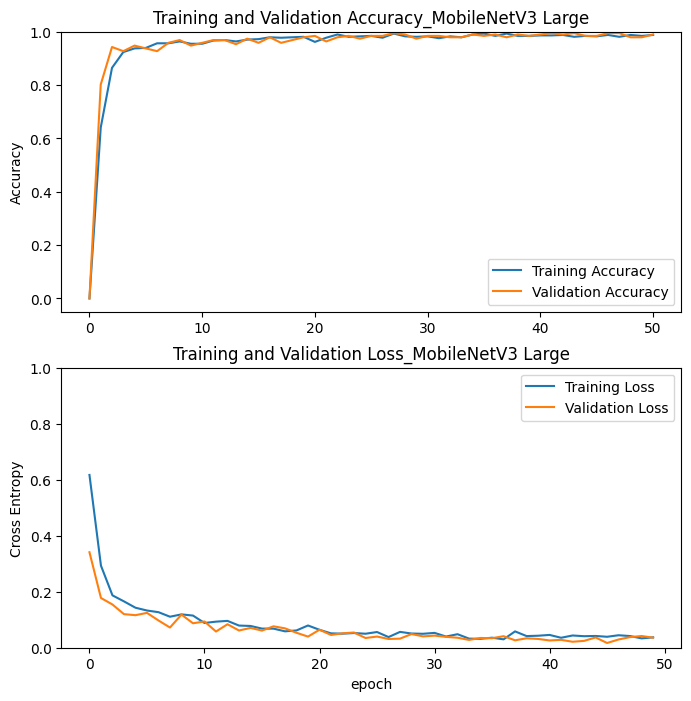

In [46]:
acc_v3_l = [0.] + history_v3_l.history['accuracy']
val_acc_v3_l = [0.] + history_v3_l.history['val_accuracy']

loss_v3_l = history_v3_l.history['loss']
val_loss_v3_l = history_v3_l.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v3_l, label='Training Accuracy')
plt.plot(val_acc_v3_l, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_MobileNetV3 Large')

plt.subplot(2, 1, 2)
plt.plot(loss_v3_l, label='Training Loss')
plt.plot(val_loss_v3_l, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_MobileNetV3 Large')
plt.xlabel('epoch')
plt.show()

In [47]:
model_v3_l.evaluate(test_dataset)

6/6 [==============================] - 1s 100ms/step - loss: 0.0278 - accuracy: 0.9946


[0.027798974886536598, 0.9946236610412598]

In [74]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_v3_l.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy for MobileNetV3 Large: {average_test_accuracy}")

Average time per evaluation run: 0.9381 seconds; Average test accuracy for MobileNetV3 Large: 0.9896057446797689


## 5 Compare 3 models performance 

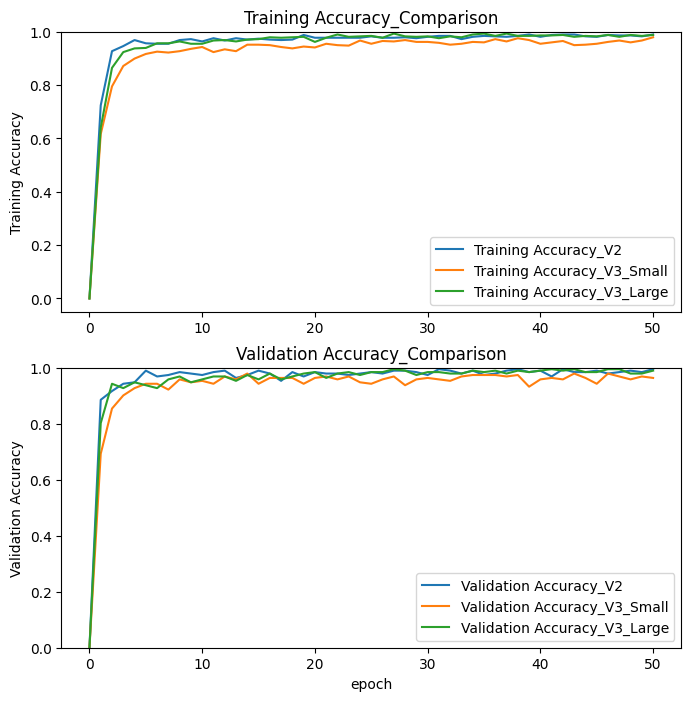

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_v2, label='Training Accuracy_V2')
plt.plot(acc_v3_s, label='Training Accuracy_V3_Small')
plt.plot(acc_v3_l, label='Training Accuracy_V3_Large')

plt.legend(loc='lower right')
plt.ylabel('Training Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy_Comparison')

plt.subplot(2, 1, 2)
plt.plot(val_acc_v2, label='Validation Accuracy_V2')
plt.plot(val_acc_v3_s, label='Validation Accuracy_V3_Small')
plt.plot(val_acc_v3_l, label='Validation Accuracy_V3_Large')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.ylim([0,1.0])
plt.title('Validation Accuracy_Comparison')
plt.xlabel('epoch')
plt.show()

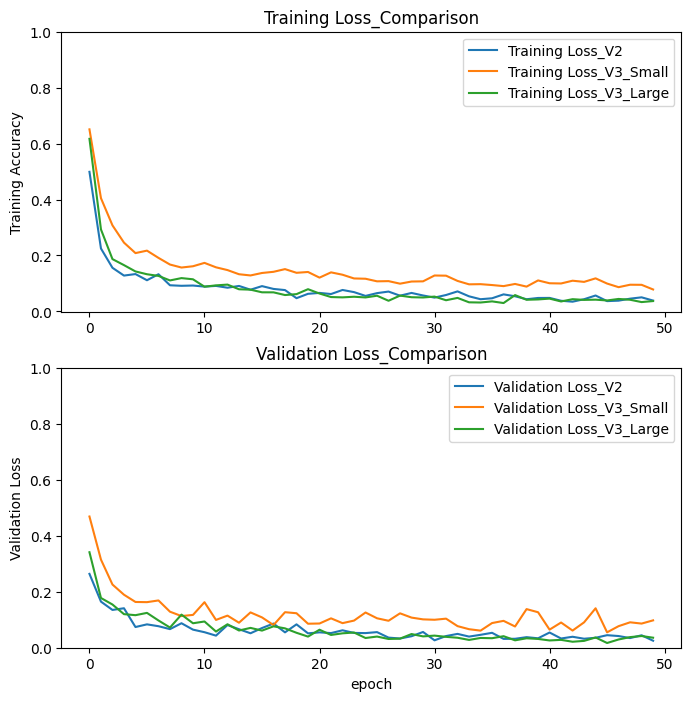

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss_v2, label='Training Loss_V2')
plt.plot(loss_v3_s, label='Training Loss_V3_Small')
plt.plot(loss_v3_l, label='Training Loss_V3_Large')

plt.legend(loc='upper right')
plt.ylabel('Training Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Loss_Comparison')

plt.subplot(2, 1, 2)
plt.plot(val_loss_v2, label='Validation Loss_V2')
plt.plot(val_loss_v3_s, label='Validation Loss_V3_Small')
plt.plot(val_loss_v3_l, label='Validation Loss_V3_Large')
plt.legend(loc='upper right')
plt.ylabel('Validation Loss')
plt.ylim([0,1.0])
plt.title('Validation Loss_Comparison')
plt.xlabel('epoch')
plt.show()

## 6 Efficient Net

In [8]:
def bear_model_ef(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,  # Exclude the final classification layers
    weights='imagenet',  # Use ImageNet pre-trained weights
    input_shape=(224, 224, 3)  # Input size to match your data
)
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) 

    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.efficientnet.preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [9]:
model_ef = bear_model_ef(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model_ef.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
history_ef = model_ef.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50  # Adjust based on your data size and convergence
)


Epoch 1/50


2024-08-17 20:28:35.235325: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8905
2024-08-17 20:28:35.293813: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 3/18 [====>.........................] - ETA: 0s - loss: 0.7081 - accuracy: 0.5312  

2024-08-17 20:28:36.598941: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f953c446dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-17 20:28:36.598977: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2024-08-17 20:28:36.602590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723919316.659358  161679 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 7s 130ms/step - loss: 0.5349 - accuracy: 0.6354 - val_loss: 0.3865 - val_accuracy: 0.6875
Epoch 2/50
18/18 [==============================] - 2s 87ms/step - loss: 0.3279 - accuracy: 0.7951 - val_loss: 0.3191 - val_accuracy: 0.7448
Epoch 3/50
18/18 [==============================] - 2s 86ms/step - loss: 0.2668 - accuracy: 0.8559 - val_loss: 0.2378 - val_accuracy: 0.8438
Epoch 4/50
18/18 [==============================] - 2s 87ms/step - loss: 0.2269 - accuracy: 0.8785 - val_loss: 0.2154 - val_accuracy: 0.8542
Epoch 5/50
18/18 [==============================] - 2s 86ms/step - loss: 0.1878 - accuracy: 0.9045 - val_loss: 0.2122 - val_accuracy: 0.8802
Epoch 6/50
18/18 [==============================] - 2s 87ms/step - loss: 0.1956 - accuracy: 0.8993 - val_loss: 0.2113 - val_accuracy: 0.8646
Epoch 7/50
18/18 [==============================] - 2s 87ms/step - loss: 0.1572 - accuracy: 0.9323 - val_loss: 0.1733 - val_accuracy: 0.8958
Epoch 8/50
18/18 [=====

In [53]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    model_ef.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)

print(f"Average time per evaluation run: {average_time:.4f} seconds")

6/6 [==============================] - 1s 83ms/step - loss: 0.0753 - accuracy: 0.9677
Test Accuracy: 0.9677


In [11]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    model_ef.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)

print(f"Average time per evaluation run: {average_time:.4f} seconds")

Average time per evaluation run: 1.0051 seconds


In [54]:
model_ef.evaluate(test_dataset)

6/6 [==============================] - 1s 29ms/step - loss: 0.0760 - accuracy: 0.9677


[0.0759873241186142, 0.9677419066429138]

In [75]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_ef.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.9886 seconds; Average test accuracy: 0.9593189915021261


In [17]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_ef.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.9862 seconds; Average test accuracy: 0.9517921050389607


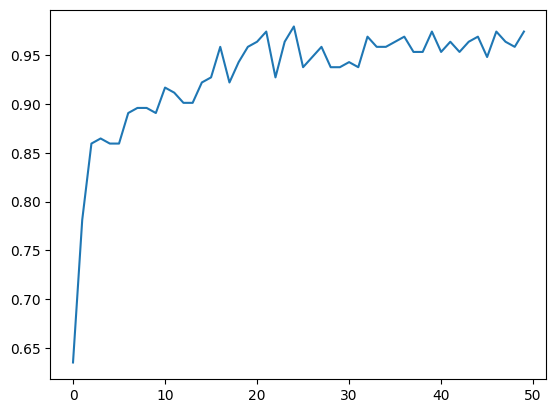

In [55]:
%matplotlib inline
plt.plot(history_ef.history['val_accuracy'], label="Efficient Net")
plt.show()

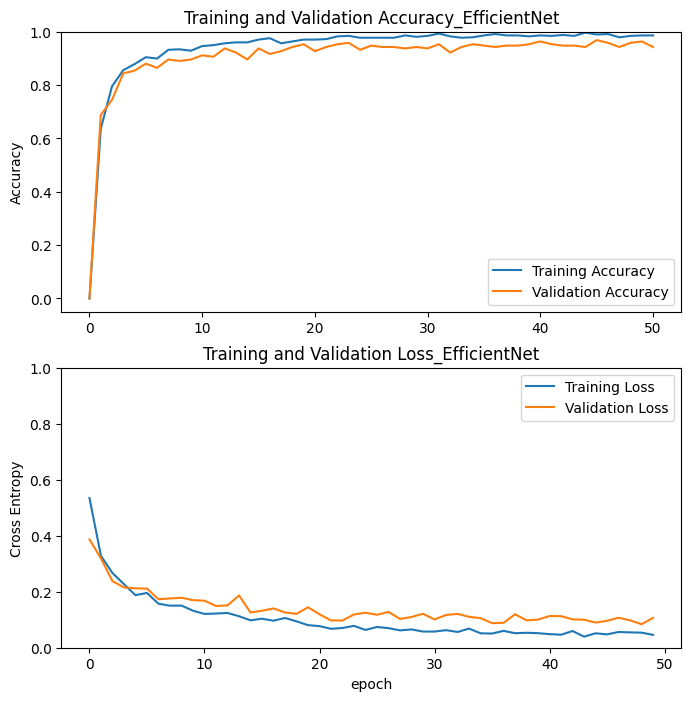

In [13]:
acc_ef = [0.] + history_ef.history['accuracy']
val_acc_ef = [0.] + history_ef.history['val_accuracy']

loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_ef, label='Training Accuracy')
plt.plot(val_acc_ef, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_EfficientNet')

plt.subplot(2, 1, 2)
plt.plot(loss_ef, label='Training Loss')
plt.plot(val_loss_ef, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_EfficientNet')
plt.xlabel('epoch')
plt.show()

## 7 Efficient Net V2

In [14]:
def bear_model_ef2(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,  # Exclude the final classification layers
    weights='imagenet',  # Use ImageNet pre-trained weights
    input_shape=(224, 224, 3)  # Input size to match your data
)
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs) 

    # data preprocessing using the same weights the model was trained on
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x) # (None, 224, 224, 3)
 
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1, activation = 'linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [15]:
model_ef2 = bear_model_ef(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model_ef2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
history_ef2 = model_ef2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50  # Adjust based on your data size and convergence
)

Epoch 1/50
18/18 [==============================] - 6s 129ms/step - loss: 0.5401 - accuracy: 0.6337 - val_loss: 0.3801 - val_accuracy: 0.7135
Epoch 2/50
18/18 [==============================] - 2s 87ms/step - loss: 0.3536 - accuracy: 0.7778 - val_loss: 0.2804 - val_accuracy: 0.8177
Epoch 3/50
18/18 [==============================] - 2s 87ms/step - loss: 0.2531 - accuracy: 0.8576 - val_loss: 0.2378 - val_accuracy: 0.8177
Epoch 4/50
18/18 [==============================] - 2s 86ms/step - loss: 0.2239 - accuracy: 0.8628 - val_loss: 0.2573 - val_accuracy: 0.8385
Epoch 5/50
18/18 [==============================] - 2s 86ms/step - loss: 0.2006 - accuracy: 0.8976 - val_loss: 0.1913 - val_accuracy: 0.8698
Epoch 6/50
18/18 [==============================] - 2s 88ms/step - loss: 0.1697 - accuracy: 0.9201 - val_loss: 0.1999 - val_accuracy: 0.8594
Epoch 7/50
18/18 [==============================] - 2s 87ms/step - loss: 0.1802 - accuracy: 0.9132 - val_loss: 0.1960 - val_accuracy: 0.8750
Epoch 8/50
1

In [59]:
model_ef2.evaluate(test_dataset)

6/6 [==============================] - 1s 28ms/step - loss: 0.0966 - accuracy: 0.9731


[0.09664908796548843, 0.9731183052062988]

In [60]:
model_ef2.evaluate(test_dataset)

6/6 [==============================] - 1s 29ms/step - loss: 0.1202 - accuracy: 0.9462


[0.12019538879394531, 0.9462365508079529]

In [61]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    model_ef2.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)

print(f"Average time per evaluation run: {average_time:.4f} seconds")

6/6 [==============================] - 1s 29ms/step - loss: 0.0584 - accuracy: 0.9731


[0.05835147574543953, 0.9731183052062988]

In [76]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_ef2.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.9891 seconds; Average test accuracy: 0.9740143458048502


In [18]:
import time
import numpy as np

# Number of times to run the evaluation
num_runs = 30
times = []
results = []
for _ in range(num_runs):
    start_time = time.time()  # Record the start time
    loss, acc = model_ef2.evaluate(test_dataset, verbose=0)  # Run evaluation without verbose output
    end_time = time.time()  # Record the end time
    results.append(acc)
    # Calculate the time taken for this run
    times.append(end_time - start_time)

# Calculate the average time per evaluation
average_time = np.mean(times)
average_test_accuracy = np.mean(results)

print(f"Average time per evaluation run: {average_time:.4f} seconds; Average test accuracy: {average_test_accuracy}")

Average time per evaluation run: 0.9879 seconds; Average test accuracy: 0.9543010671933492


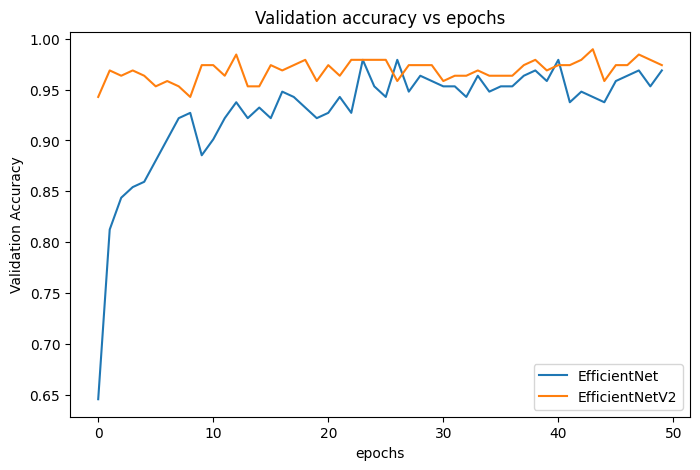

In [65]:
plt.figure(figsize=(8,5))
plt.title('Validation accuracy vs epochs')
plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')
plt.show()

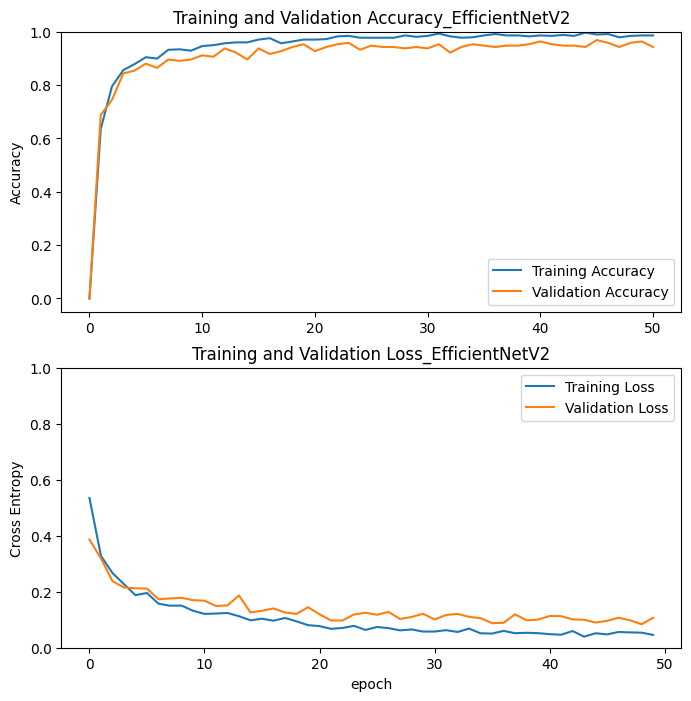

In [20]:
acc_ef = [0.] + history_ef.history['accuracy']
val_acc_ef = [0.] + history_ef.history['val_accuracy']

loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_ef, label='Training Accuracy')
plt.plot(val_acc_ef, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy_EfficientNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss_ef, label='Training Loss')
plt.plot(val_loss_ef, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss_EfficientNetV2')
plt.xlabel('epoch')
plt.show()

## 8 Yolo

In [77]:
import os
from ultralytics import YOLO
# numpy 1,24.2

In [78]:
DATA_DIR = '/home/jupyter-yixuan/project_machine_learning/Yolo_bear_non_bear'

In [79]:
# Load a model
model = YOLO("yolov8n-cls.pt")  # load a pretained model

# Use the model
results = model.train(data=DATA_DIR, epochs=50, imgsz=160)  # train the model

/home/jupyter-yixuan/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu

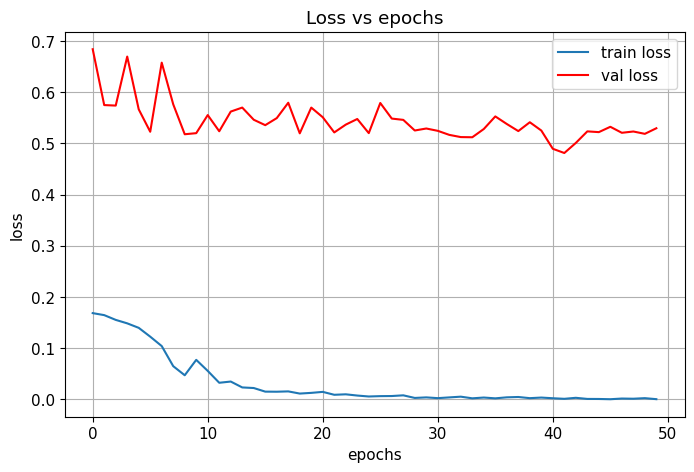

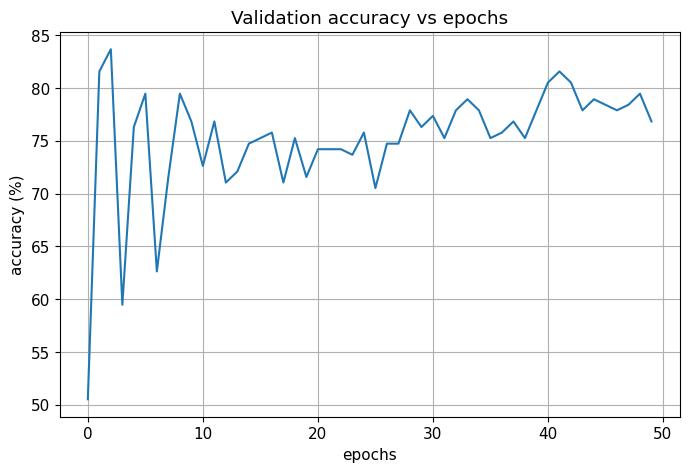

In [97]:
import os
import pandas as pd
import matplotlib.pyplot as plt

results_path = '/home/jupyter-yixuan/project_machine_learning/runs/classify/train9/results.csv'
df = pd.read_csv(results_path)

plt.figure(figsize=(8,5))
plt.plot(df['                  epoch'], df['             train/loss'], label='train loss')
plt.plot(df['                  epoch'], df['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure(figsize=(8,5))
plt.plot(df['                  epoch'], df['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

### Predict

In [81]:
from ultralytics import YOLO

import numpy as np

model_path = '/home/jupyter-yixuan/project_machine_learning/runs/classify/train6/weights/best.pt'
example_path = '/home/jupyter-yixuan/project_machine_learning/angry_bears/images/18.jpeg'

model = YOLO(model_path)  # load a custom model

results = model(example_path)  # predict on an image

names_dict = results[0].names

probs = results[0].probs.data.tolist()

print(names_dict)
print(probs)

print(names_dict[np.argmax(probs)])

/home/jupyter-yixuan/.local/lib/python3.10/site-packages/ultralytics/nn/tasks.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu

{0: 'Bear', 1: 'Non Bear'}
[0.9898812174797058, 0.010118712671101093]
Bear


## 9 Compare 6 models performance 

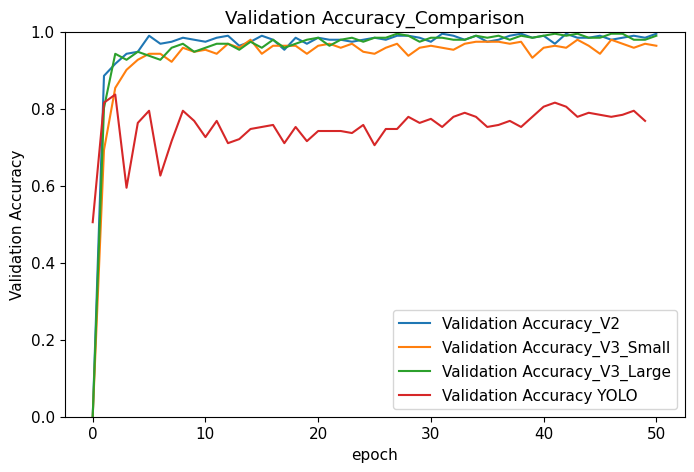

In [98]:

plt.figure(figsize=(8,5))
plt.plot(val_acc_v2, label='Validation Accuracy_V2')
plt.plot(val_acc_v3_s, label='Validation Accuracy_V3_Small')
plt.plot(val_acc_v3_l, label='Validation Accuracy_V3_Large')

plt.ylim([0,1.0])


plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')
# plt.grid()
plt.title('Validation accuracy vs epochs')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.title('Validation Accuracy_Comparison')
plt.xlabel('epoch')
plt.show()

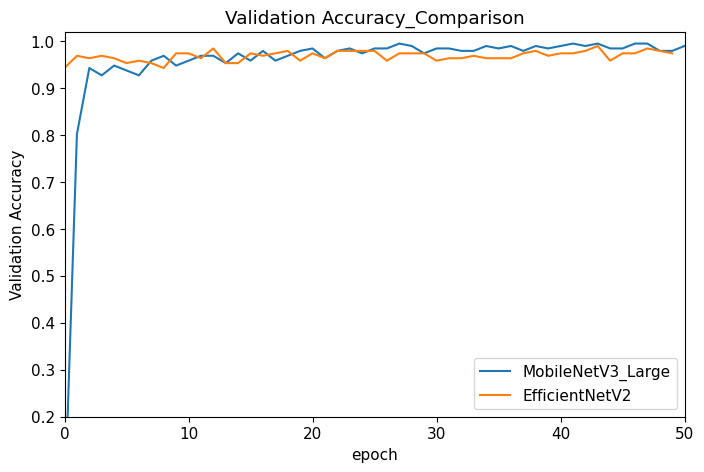

In [103]:
plt.figure(figsize=(8,5))
# plt.plot(val_acc_v2, label='MobileNetV2')
# plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
# plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")

plt.ylim([0.2,1.02])
plt.xlim([0,50])

# plt.plot( results['  metrics/accuracy_top1'], label = 'YOLO')
# plt.grid()
plt.title('Validation accuracy vs epochs')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.title('Validation Accuracy_Comparison')
plt.xlabel('epoch')
plt.show()

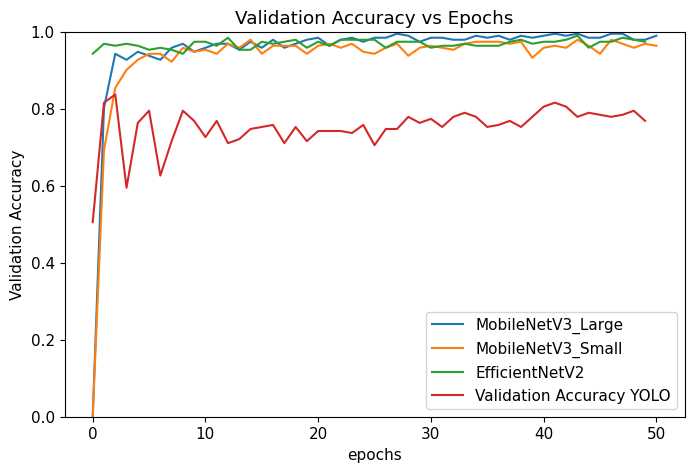

In [101]:
plt.figure(figsize=(8,5))
# plt.plot(val_acc_v2, label='Validation Accuracy_V2')
# plt.plot(val_acc_v3_s, label='Validation Accuracy_V3_Small')
plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
# plt.plot(val_acc_v2, label='MobileNetV2')
plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
# plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")
plt.ylim([0,1.0])


plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')
# plt.grid()
plt.title('Validation Accuracy vs Epochs')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.show()

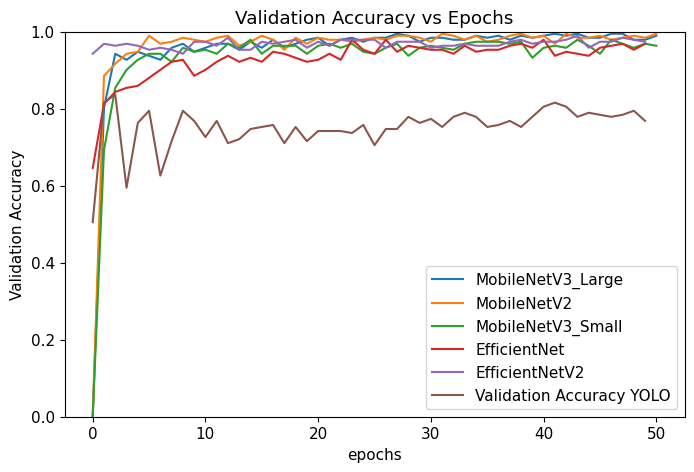

In [102]:
plt.figure(figsize=(8,5))

plt.plot(val_acc_v3_l, label='MobileNetV3_Large')
plt.plot(val_acc_v2, label='MobileNetV2')
plt.plot(val_acc_v3_s, label='MobileNetV3_Small')
plt.plot(history_ef.history['val_accuracy'], label="EfficientNet")
plt.plot(history_ef2.history['val_accuracy'], label="EfficientNetV2")
plt.ylim([0,1.0])


plt.plot( df['  metrics/accuracy_top1'], label = 'Validation Accuracy YOLO')
# plt.grid()
plt.title('Validation Accuracy vs Epochs')
plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
plt.xlabel('epochs')

plt.show()